<a href="https://colab.research.google.com/github/Chri1629/dsim_project/blob/main/image/ambulanze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import librosa
import re
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Advanced audio features
import librosa.display
from sklearn.preprocessing import scale

In [38]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

base_dir = "gdrive/MyDrive/ambulanze/"

Mounted at /content/gdrive


In [39]:
trainAV = pd.read_csv("gdrive/MyDrive/train.csv")
testAV = pd.read_csv("gdrive/MyDrive/test_vc2kHdQ.csv")

In [40]:
print(len(trainAV) + len(testAV))

7290


In [41]:
trainAV.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [42]:
trainAV.loc[trainAV['image_names'] == '4.jpg']

,image_names,emergency_or_not
1316,4.jpg,1


In [70]:
def add_class():
  for f in sorted(os.listdir(base_dir)[0:10]):
    print(f)
    if f.endswith('.jpg'):
      name = re.search(r'^(\d+)\.jpg$', f).group(1)

      a = plt.imread(base_dir + f)      
      fig = plt.figure(figsize=(4,4))
      ax = fig.add_subplot(111)

      ax.imshow(a)

      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
      ax.set_frame_on(False)

      if f in trainAV['image_names'].values:
        label = trainAV.loc[trainAV['image_names'] == f]['emergency_or_not'].values[0] 

      elif f in testAV['image_names'].values:
        label = 2

      if int(label) == 0:
          fig.savefig("gdrive/MyDrive/emergency_models/class_{}/{}.jpg".format(label, name), dpi = 100, bbox_inches = 'tight',
    pad_inches = 0)

      elif int(label) == 1:
          fig.savefig("gdrive/MyDrive/emergency_models/class_{}/{}.jpg".format(label, name), dpi = 100, bbox_inches = 'tight',
    pad_inches = 0)

      elif int(label) == 2:
          fig.savefig("gdrive/MyDrive/emergency_models/class_test/{}.jpg".format(name), dpi = 100, bbox_inches = 'tight',
    pad_inches = 0)
      print(f)

6913.jpg
6913.jpg
709.jpg
709.jpg
720.jpg
720.jpg
7285.jpg
7285.jpg
7347.jpg
7347.jpg
7715.jpg
7715.jpg
810.jpg
810.jpg
8315.jpg
8315.jpg
8340.jpg
8340.jpg
train.csv


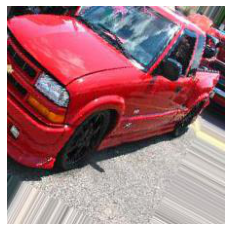

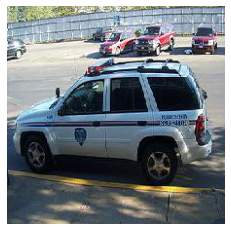

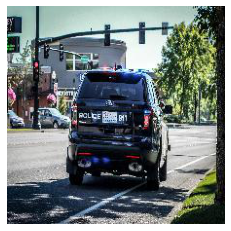

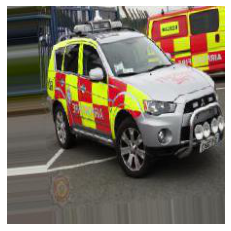

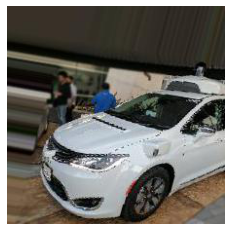

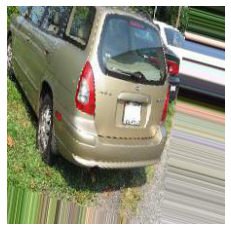

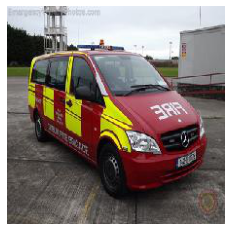

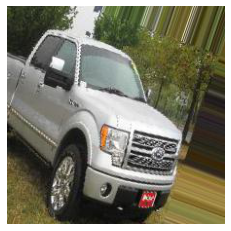

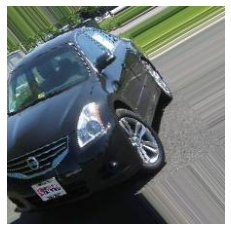

In [71]:
add_class()

Ora che abbiamo il vettore di label bisogna separare le immagini in due sotto directory in modo che siano facilmente importabili con tensorflow

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("gdrive/MyDrive/emergency_models", output="gdrive/MyDrive/emergency_true_models", ratio=(0.6, 0.3, 0.1))

Copying files: 0 files [00:00, ? files/s]


# Modelli

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import xception

In [ ]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = xception.preprocess_input)

train_generator = train_processing.flow_from_directory("gdrive/MyDrive/ambulanze_model/train",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1)

x_train, y_train = next(train_generator)

FileNotFoundError: ignored

In [ ]:
validation_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

validation_generator = validation_processing.flow_from_directory("gdrive/MyDrive/ambulanze_model/val",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1)
x_validation, y_validation = next(validation_generator)

In [ ]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

test_generator = test_processing.flow_from_directory("gdrive/MyDrive/ambulanze_model/test",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)
x_test, y_test = next(test_generator)

In [ ]:
from tensorflow.keras.applications import xception
base_net = xception.Xception(input_shape = (224,224,3),
                        weights = 'imagenet',
                        include_top = False,
                        pooling = 'avg')

In [ ]:
for layer in base_net.layers:
    layer.trainable = False

In [ ]:
x = base_net.output

x = keras.layers.Dense(64, activation = "relu") (x)
pred = keras.layers.Dense(2, activation = 'sigmoid') (x)

In [ ]:
net1 = keras.Model(inputs = base_net.input, outputs = pred)

In [ ]:
net1.compile(loss = keras.losses.categorical_crossentropy,
           optimizer = keras.optimizers.RMSprop(),
           metrics = ['accuracy'])

In [ ]:
hist1 = net1.fit(train_generator,
       epochs = 5,
       validation_data = validation_generator)

In [ ]:
def acc_loss(history):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label = "Train loss", color = "red")
    plt.plot(history.history['val_loss'], label="Validation loss", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Loss', size = 15) 
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label = "Train accuracy", color = "red")
    plt.plot(history.history['val_accuracy'], label="Validation accuracy", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Accuracy', size = 15) 

In [ ]:
acc_loss(hist1)

In [ ]:
acc1 = net1.evaluate(test_generator)

In [ ]:
pred_1 = net1.predict(test_generator)

In [ ]:
pred_1 = np.argmax(pred_1, axis = 1)

In [ ]:
print(classification_report(test_generator.classes, pred_1))

In [ ]:
cm = confusion_matrix(test_generator.classes, pred_1)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 
#ax.set_yticklabels(['Letto', 'Improvvisato'], rotation=90, ha='right', minor=False)

plt.title("Confusion matrix", size = 20)